<h1>MBA Upload and Download Speed Metric Charts Multiple Concurrent TCP Connections </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>

<h7>3/20/22</h7>

In [2]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [115]:
%%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

<h3> Initial BigQuery SQL Speed Queries </h3>
<p>IPv4 with multiple concurrent TCP connections</p>

<h5>Download Queries and Dataframes</h5>

In [117]:
# DOWNLOAD***

peak_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    --APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        --PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE)) 
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""

fullDay_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        -- PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))

    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""


# Creating main dataframes
peak_download = client.query(peak_download_sql).to_dataframe()
fullDay_download = client.query(fullDay_download_sql).to_dataframe()
print("Executed")

Executed


<h5>Upload Queries and Dataframes</h5>


In [5]:
peak_upload_sql = """

SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))    
        ) 
GROUP BY mt_upload, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_upload
) as queryA

JOIN

(SELECT DISTINCT 
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_upload as INT64)) as _80_80_,
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))    
    ) 
    ORDER BY mt_upload
) as queryB

ON queryA.upload_service_tier = queryB.upload_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech
ORDER BY queryA.upload_service_tier, queryA.ISP, queryA.tech

"""

fullDay_upload_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_upload, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_upload
) as queryA

JOIN

(SELECT DISTINCT 
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_upload as INT64)) as _80_80_,
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
    ORDER BY mt_upload
) as queryB

ON queryA.upload_service_tier = queryB.upload_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech
ORDER BY queryA.upload_service_tier, queryA.ISP, queryA.tech


"""

peak_upload = client.query(peak_upload_sql).to_dataframe()
fullDay_upload = client.query(fullDay_upload_sql).to_dataframe()
print("Executed")

Executed


<h3> Python functions for normalizing dataframes to tiers

In [51]:
def dfNormalizerD(df):
    
    ispTech =  df['download_service_tier'].astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']       
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['download_service_tier']
    isp = df['ISP']
    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty ))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result

def dfNormalizerU(df):
    
    ispTech =  df['upload_service_tier'].astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']   
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['upload_service_tier'] 
    isp = df['ISP']
        
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result
    

    




In [52]:
# DSL ISPs: Windstream + Centurylink
# Cable ISPs: Comcast, Optimum, Mediacom
# Fiber ISPs: Frontier, Verizon 


# Download dataframes
peakDChart = dfNormalizerD(peak_download) 
offPeakDChart = dfNormalizerD(fullDay_download) 

# Peak Download Dataframes by Tech

# Peak Download DSL
peakDDSL = peakDChart.where(peakDChart.tech =='DSL').dropna()
peakDDSL = peakDDSL[(peakDDSL['isp'] =='Windstream') | (peakDDSL['isp'] =='CenturyLink')]


# Peak Download Cable
peakDCable = peakDChart.where(peakDChart.tech =='Cable').dropna()
peakDCable = peakDCable[(peakDCable['isp'] =='Comcast') | (peakDCable['isp'] =='Optimum') | 
                        (peakDCable['isp'] =='Mediacom')]

# Peak Download Fiber
peakDFiber = peakDChart.where(peakDChart.tech =='Fiber').dropna()
peakDFiber = peakDFiber[(peakDFiber['isp'] =='Frontier') | (peakDFiber['isp'] =='Verizon')]




# OffPeak Download Dataframes by Tech

# Fullday Download DSL 
normDDSL = offPeakDChart.where(offPeakDChart.tech =='DSL').dropna()
normDDSL = normDDSL[(normDDSL['isp'] =='Windstream') | (normDDSL['isp'] =='CenturyLink')]


# Fullday Download Cable
normDCable = offPeakDChart.where(offPeakDChart.tech =='Cable').dropna()
normDCable = normDCable[(normDCable['isp'] =='Comcast') | (normDCable['isp'] =='Optimum') | 
                        (normDCable['isp'] =='Mediacom')]


# Fullday Download Fiber
normDFiber = offPeakDChart.where(offPeakDChart.tech =='Fiber').dropna()
normDFiber = normDFiber[(normDFiber['isp'] =='Frontier') | (normDFiber['isp'] =='Verizon')]






# Upload dataframes
peakUChart = dfNormalizerU(peak_upload) 
offPeakUChart = dfNormalizerU(fullDay_upload) 


# Peak Upload Dataframes by tech

# Peak Upload DSL
peakUDSL = peakUChart.where(peakUChart.tech =='DSL').dropna()
peakUDSL = peakUDSL[(peakUDSL['isp'] =='Windstream') | (peakUDSL['isp'] =='CenturyLink')]


# Peak Upload Cable
peakUCable = peakUChart.where(peakUChart.tech =='Cable').dropna()
peakUCable = peakUCable[(peakUCable['isp'] =='Comcast') | (peakUCable['isp'] =='Optimum') | 
                        (peakUCable['isp'] =='Mediacom')]

# Peak Upload Fiber
peakUFiber = peakUChart.where(peakUChart.tech =='Fiber').dropna()
peakUFiber = peakUFiber[(peakUFiber['isp'] =='Frontier') | (peakUFiber['isp'] =='Verizon')]





# OffPeak Upload Dataframes by tech
normUDSL = offPeakUChart.where(offPeakUChart.tech =='DSL').dropna()
normUDSL = normUDSL[(normUDSL['isp'] =='Windstream') | (normUDSL['isp'] =='CenturyLink')]


# Fullday Upload Cable
normUCable = offPeakUChart.where(offPeakUChart.tech =='Cable').dropna()
normUCable = normUCable[(normUCable['isp'] =='Comcast') | (normUCable['isp'] =='Optimum') | 
                        (normUCable['isp'] =='Mediacom')]



# Fullday Upload Fiber
normUFiber = offPeakUChart.where(offPeakUChart.tech =='Fiber').dropna()
normUFiber = normUFiber[(normUFiber['isp'] =='Frontier') | (normUFiber['isp'] =='Verizon')]



<h3> Download Speed Charts

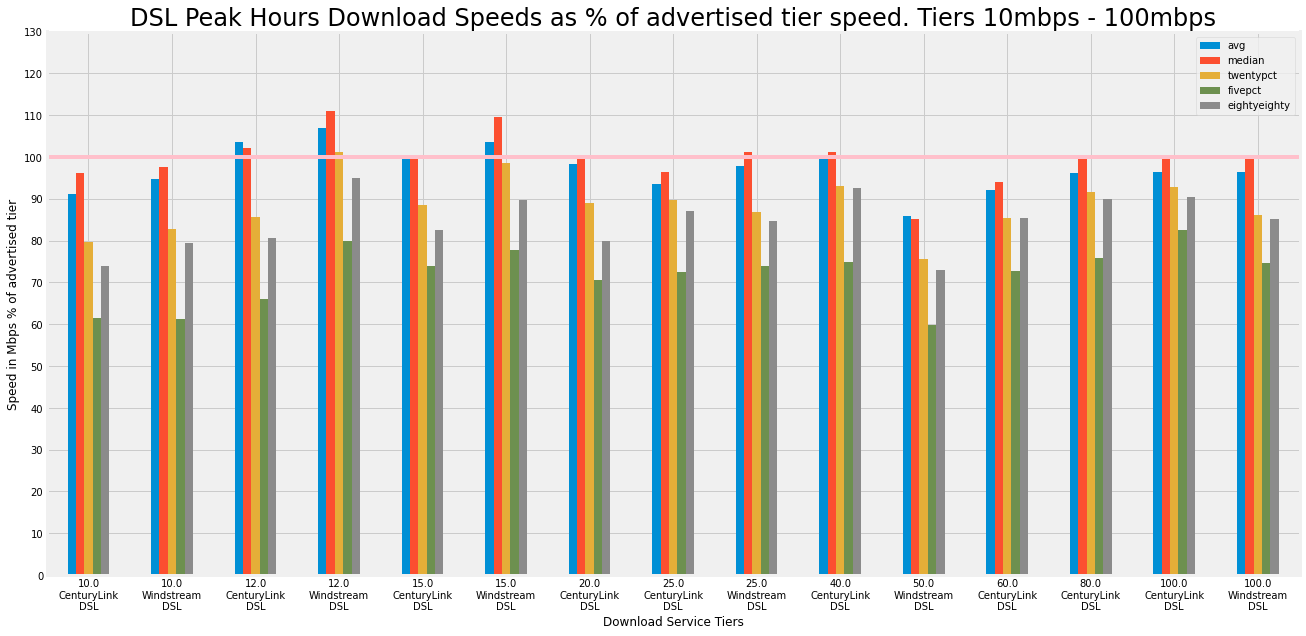

In [84]:
chartData = peakDDSL
chartData = chartData[chartData.tier >= 10]




ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('DSL Peak Hours Download Speeds as % of advertised tier speed. Tiers 10mbps - 100mbps', fontsize=24)


plt.show()

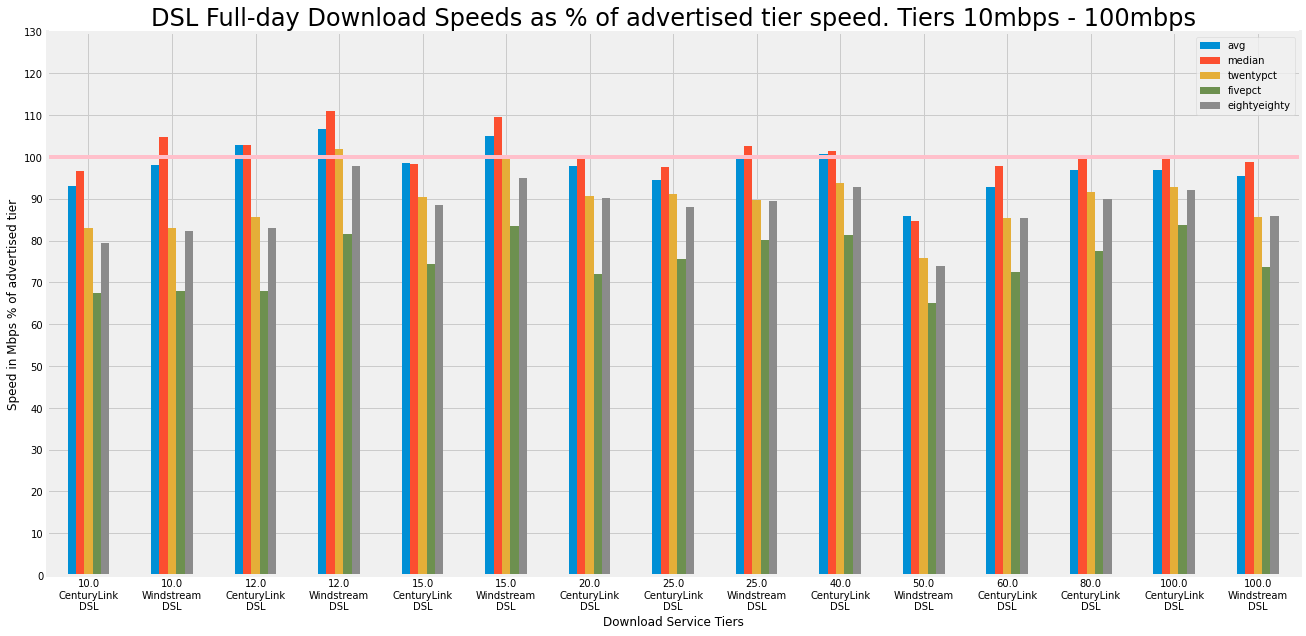

In [85]:
chartData = normDDSL
chartData = chartData[chartData.tier >=10]


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('DSL Full-day Download Speeds as % of advertised tier speed. Tiers 10mbps - 100mbps', fontsize=24)


plt.show()

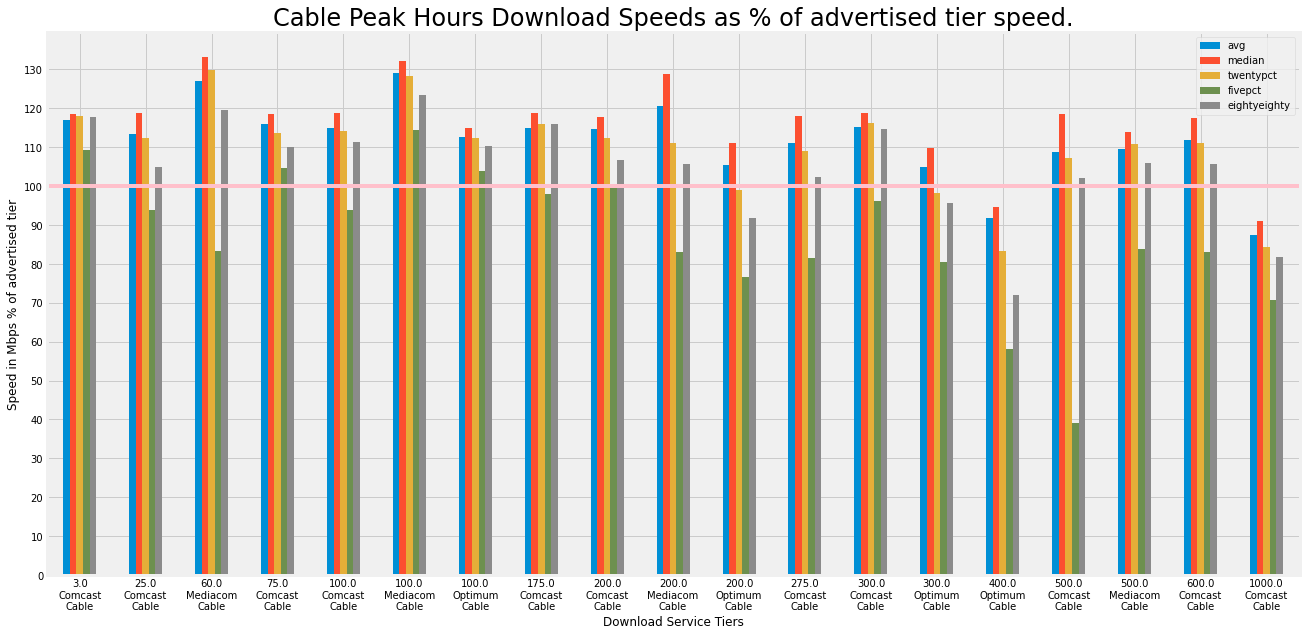

In [86]:
chartData = peakDCable



ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 140, 10))

plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Cable Peak Hours Download Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

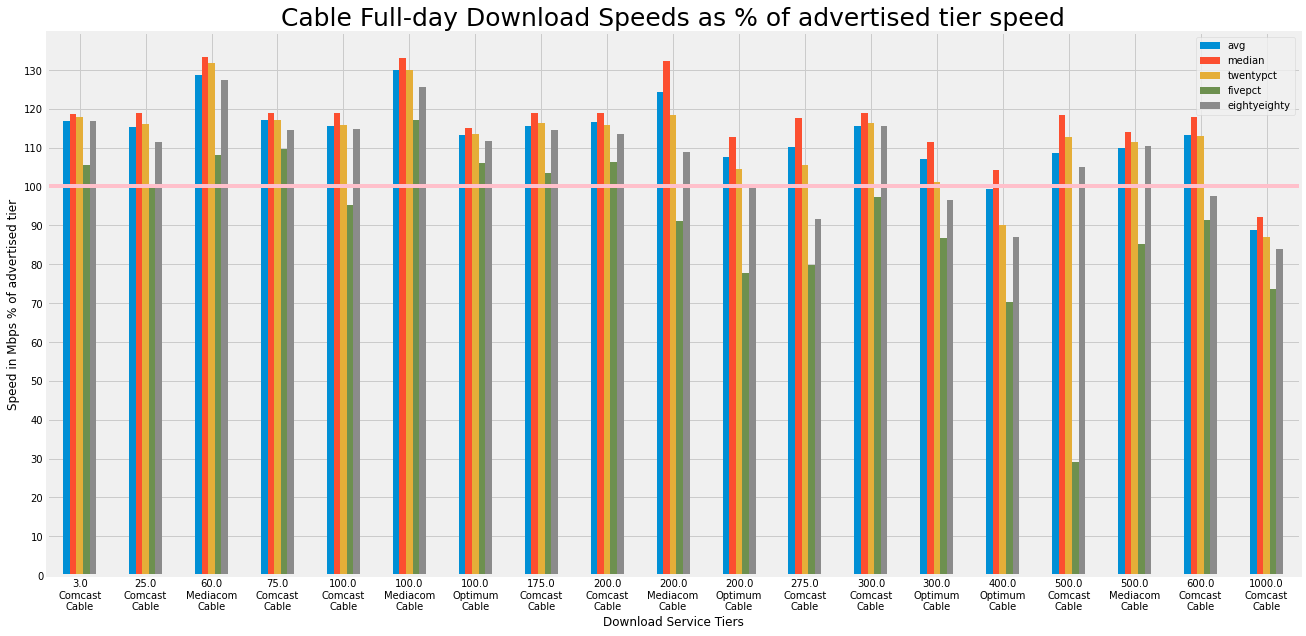

In [87]:
chartData = normDCable


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Cable Full-day Download Speeds as % of advertised tier speed', fontsize=25)


plt.show()

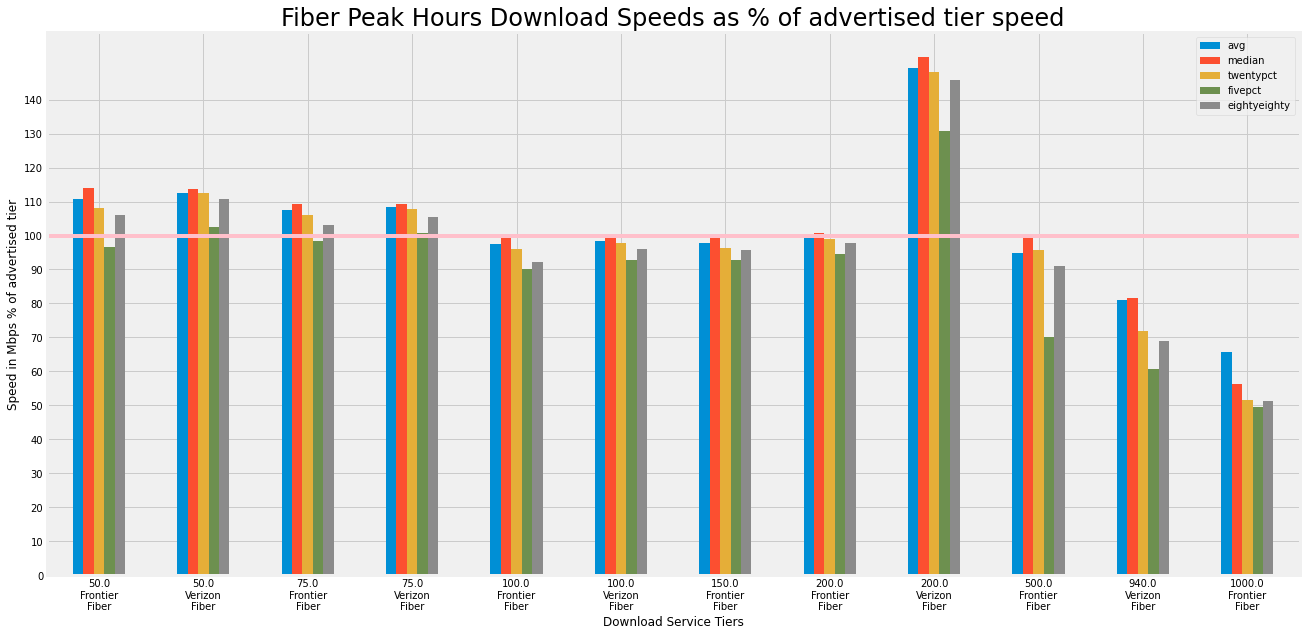

In [88]:
chartData = peakDFiber

ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 150, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Fiber Peak Hours Download Speeds as % of advertised tier speed', fontsize=24)


plt.show()

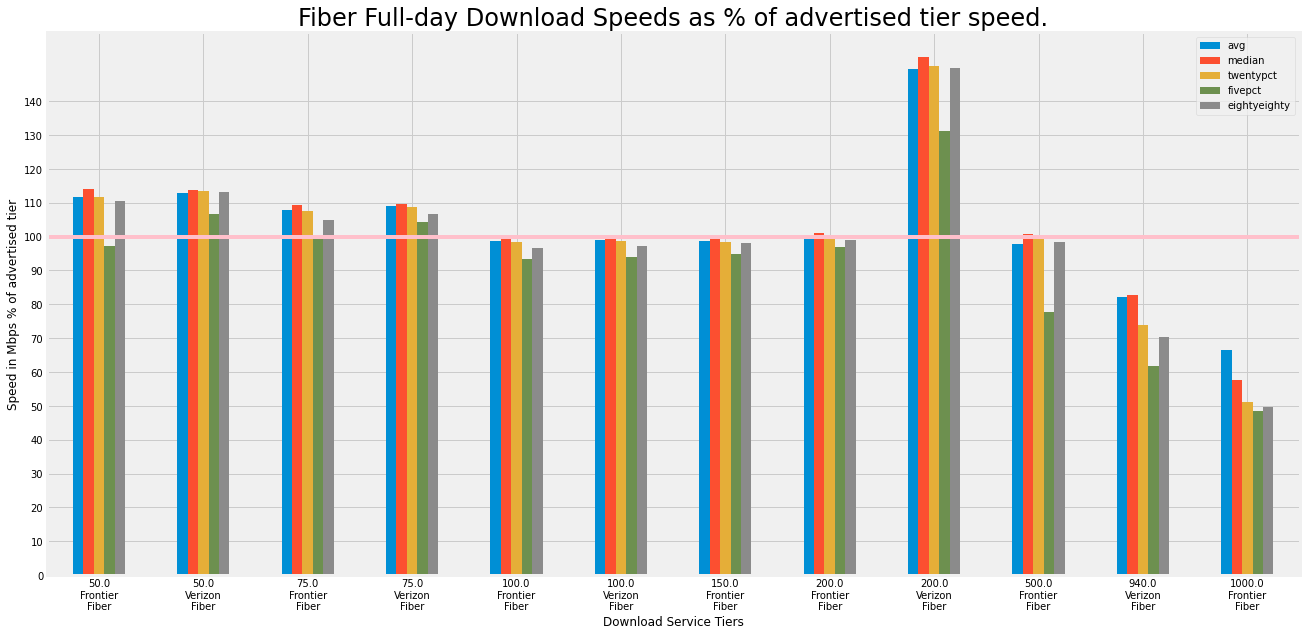

In [90]:
chartData = normDFiber

ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 150, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Fiber Full-day Download Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

<hr>

<h3> Upload Speed Charts

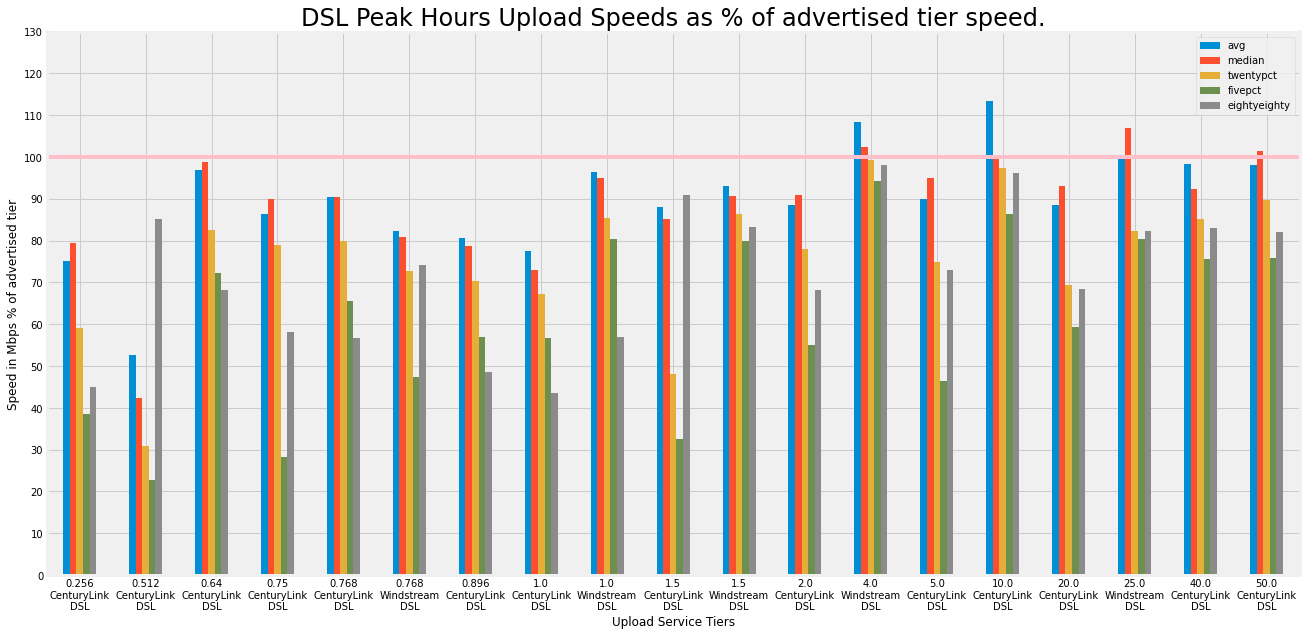

In [104]:
chartData = peakUDSL



ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('DSL Peak Hours Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

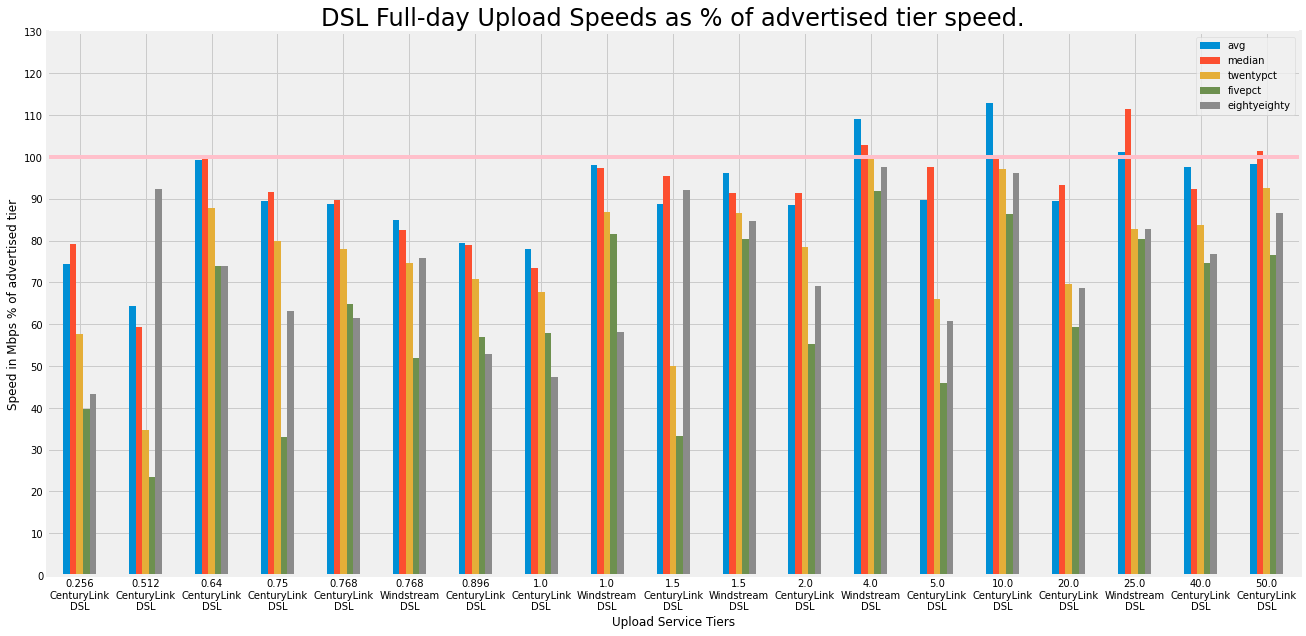

In [101]:
chartData = normUDSL



ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('DSL Full-day Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

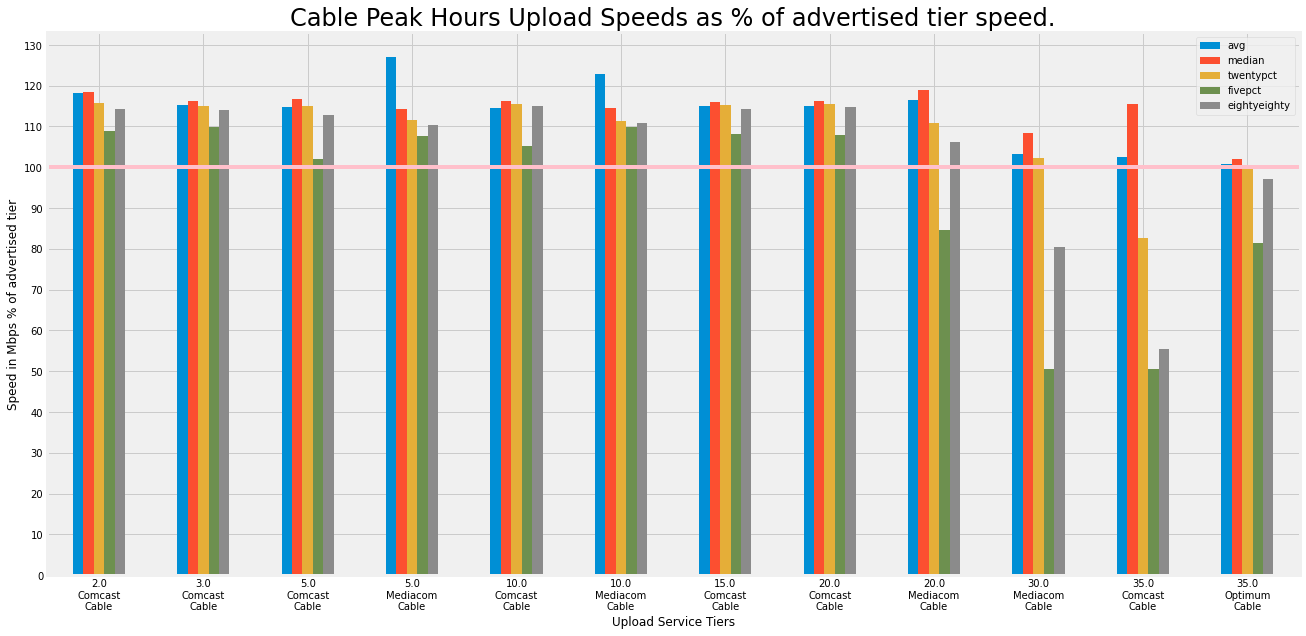

In [100]:
chartData = peakUCable


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Cable Peak Hours Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

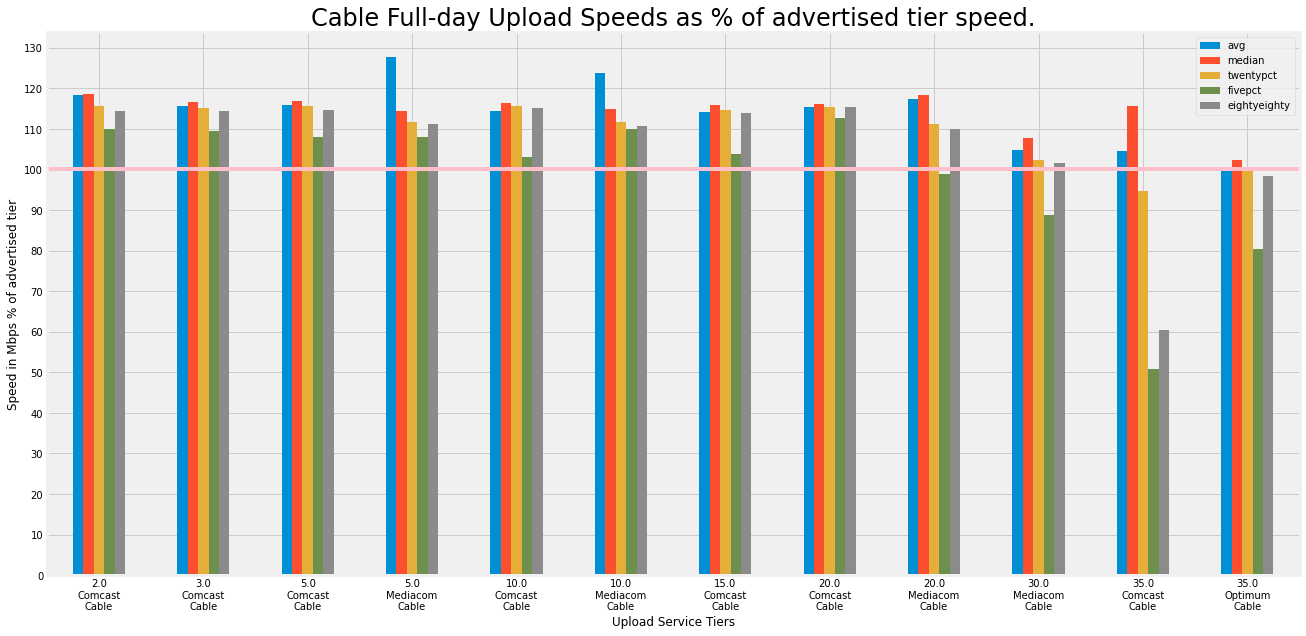

In [105]:
chartData = normUCable


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Cable Full-day Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

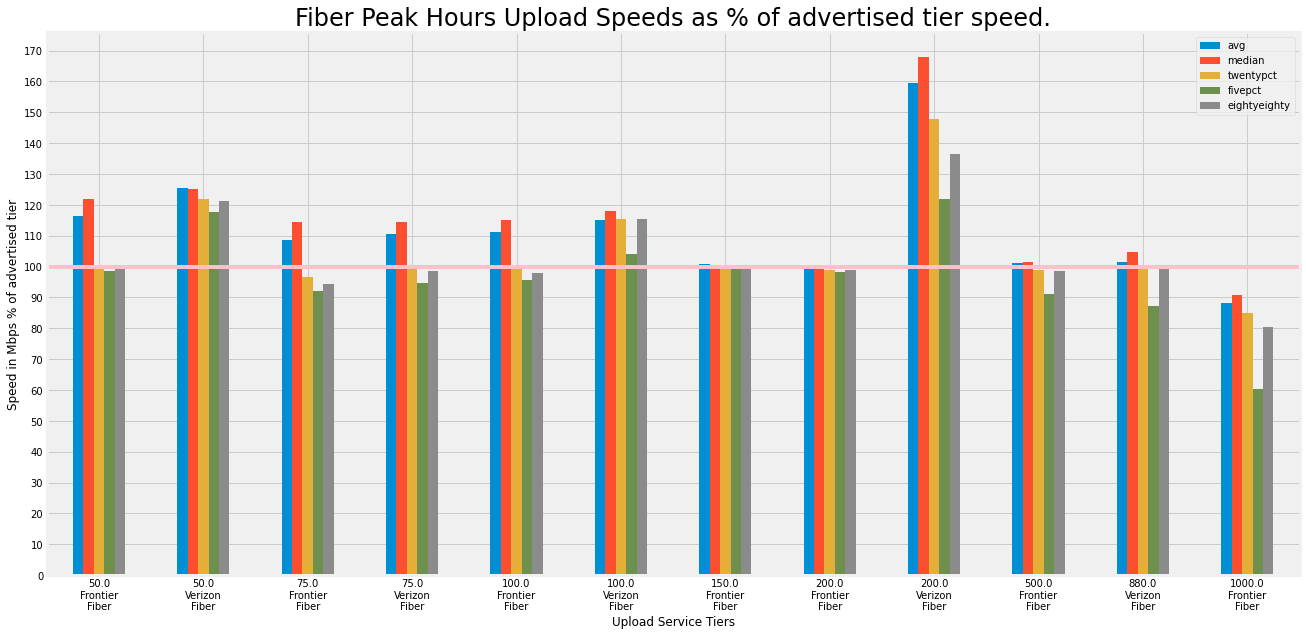

In [108]:
# chartData = peakUChart
# chartData = chartData[chartData.tier > 20]
# chartData = chartData[chartData.tier <= 100]

chartData = peakUFiber


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 180, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Fiber Peak Hours Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

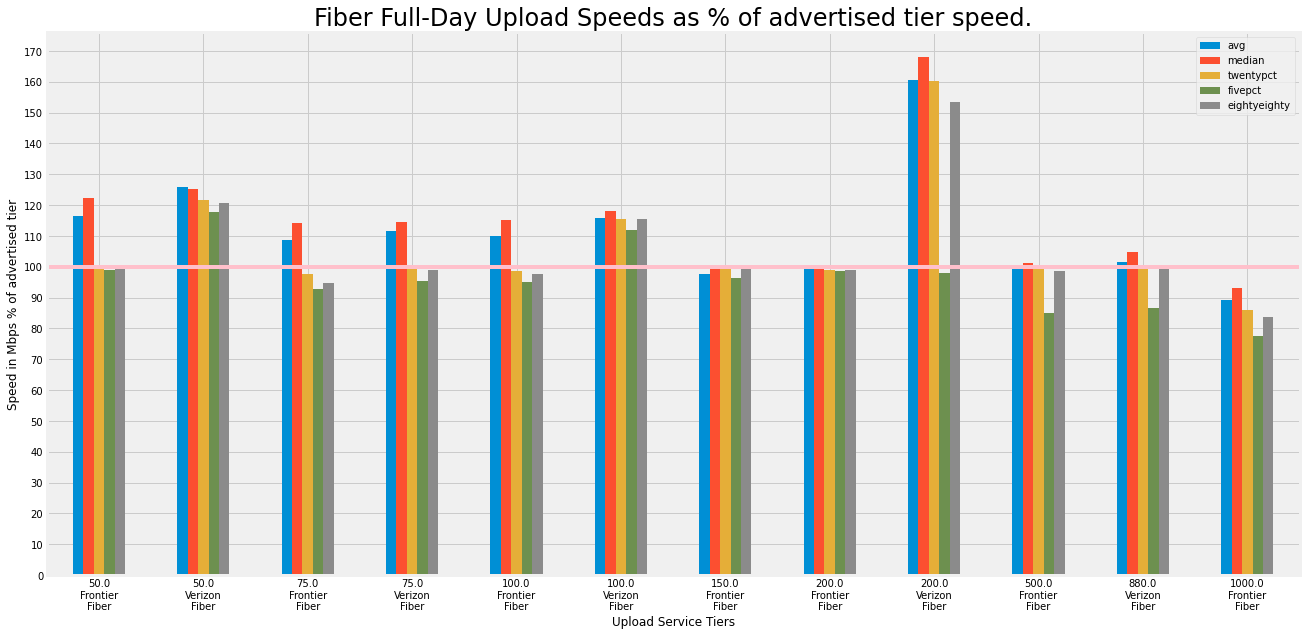

In [116]:

chartData = normUFiber


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 180, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Fiber Full-Day Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()